In [2]:
import keras

import matplotlib.pyplot as plt
from zipfile import ZipFile
import numpy as np
from keras.utils import np_utils

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import MaxPooling2D
from keras.layers import Convolution2D
from keras.layers import Flatten

seed = 109343164
np.random.seed(seed)

import numpy as np # linear algebra
import pandas as pd 

import os, sys
from IPython.display import display
from IPython.display import Image as _Imgdis
import numpy as np
from time import time
from time import sleep
# import Image
from PIL import Image # PIL == Pillow
import cv2


Using TensorFlow backend.


In [3]:
# folder = "./video_results/bounding_boxes"
folder = r'C:\Users\grant\Documents\School\Deep Learning\Project_v2\trunk\video_results\all_boxes'

# images = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
images = []
for f in os.listdir(folder):
    if os.path.isfile(os.path.join(folder, f)):
        images.append(f)
        
import re
def sorted_aphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

images = sorted_aphanumeric(images)


type of raw_images
<class 'numpy.ndarray'>
type of raw_images[0]
<class 'numpy.ndarray'>
shape of raw_images[0]
(250, 250, 3)
(1935, 250, 250, 3)


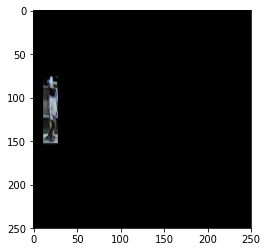

In [4]:
import cv2
raw_images=[]
grounds=[]
for i in range(0, len(images)):
    if "z" in images[i]:
        grounds.append(1)
    else:
        grounds.append(0)
    img = cv2.imread(filename=folder + "/" + images[i])
    raw_images.append(img)
    

raw_images = np.array(raw_images)
    
# CV2 reads in images as ndArray
print('type of raw_images')
print(type(raw_images))
print('type of raw_images[0]')
print(type(raw_images[0]))
print('shape of raw_images[0]')
print(raw_images[0].shape)
print(raw_images.shape)
plt.imshow(raw_images[0])



In [5]:
# resize and scale pix values in all images
raw_images = raw_images.reshape(raw_images.shape[0], 250*250*3).astype('float32') # as float32 so that nums are smaller, take less memory
print(raw_images.shape)
raw_images = (raw_images-np.min(raw_images))/(np.max(raw_images)-np.min(raw_images))
raw_images.resize(raw_images.shape[0], 250, 250, 3)

(1935, 187500)


In [5]:
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
num_of_classes=2

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.layers import Flatten
def baselineCNN():
    m = Sequential()
    # first hidden layer
    m.add(Conv2D(filters=40,
                kernel_size=(10,10),
                input_shape=(250,250,3), # check this
                activation='relu')) 
    # pooling layer
    m.add(
        MaxPooling2D(pool_size=(4,4))
    )
    # Flattening Layer
    m.add(
        Flatten()
    )
    #Fully connected layer
    m.add(
        Dense(
            units=200,
            activation='relu'
        )
    )
    #Output layer
    m.add(
        Dense(
            units=num_of_classes,
            activation='softmax'
        )
    )
    #compile model
    m.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    #return the model
    return m

In [7]:
model = baselineCNN()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 241, 241, 40)      12040     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 40)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 144000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               28800200  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 402       
Total params: 28,812,642
Trainable params: 28,812,642
Non-trainable params: 0
_________________________________________________________________
None


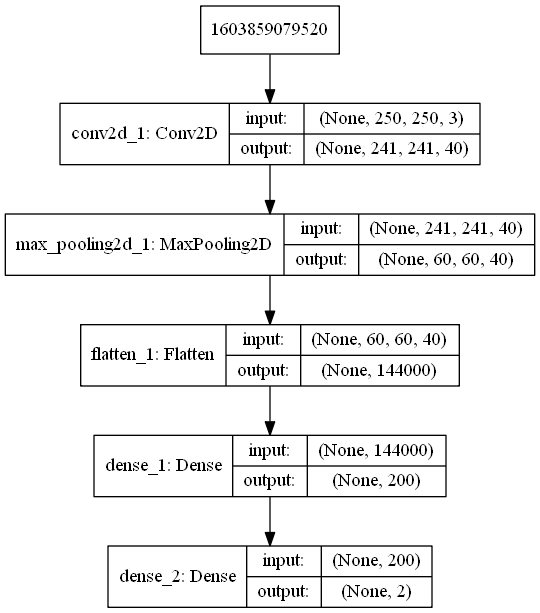

In [8]:
# Visualize the model
# Pre-req: conda install pydot graphviz
# And/or:  sudo apt install graphviz libgraphviz-dev

from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
plot_model(model, to_file='part 1 model_plot_small_CNN.png', show_shapes=True, show_layer_names=True)
#Best way to display the image
from IPython.display import Image,SVG
Image(filename='part 1 model_plot_small_CNN.png') 

In [9]:
# current timestamp as the log filename 
import time
t = time.localtime(time.time())
timeStamp = str(t.tm_year) + '-' + str(t.tm_mon) + '-' + str(t.tm_mday) + '--' + str(t.tm_hour) + '-'+str(t.tm_min) + '-'+str(t.tm_sec)
timeStamp

## Create a TensorBoard instance with the path to the logs directory
from keras.callbacks import TensorBoard
tBoard = TensorBoard(log_dir='logs/{}'.format(timeStamp))
# http://laptop-91672tml:6006/#scalars

In [10]:
# split training and test data manually, don't want randomization
eighty_idx = int(len(raw_images) * .80)
grounds = np.array(grounds)
print(grounds.shape)
xtrain, ytrain = raw_images[:eighty_idx], grounds[:eighty_idx]
xtest,  ytest  = raw_images[eighty_idx:], grounds[eighty_idx:]
print(len(raw_images))
print(len(xtrain))
print(len(xtest))
print(len(xtest) + len(xtrain))
ytrain = np_utils.to_categorical(ytrain)
ytest = np_utils.to_categorical(ytest)
print(ytest[8])

(1935,)
1935
1548
387
1935
[0. 1.]


In [ ]:
# Fit the model, and record history of training results
# define the params
num_epochs = 5
batch_size = 200

history = model.fit(
    xtrain,
    ytrain,
    validation_data=(xtest,ytest),
    epochs=num_epochs,
    batch_size=batch_size,
    verbose=2,
    callbacks=[tBoard]
)

Train on 1548 samples, validate on 387 samples
Epoch 1/5


In [ ]:
pth = input('enter the full path for storing weights, or enter 0 to skip this')
import os
no_go=True
if pth != '0':
	while no_go:
		try:
			os.path.isdir(pth)
		except:
			pth = input('enter the full path for storing weights, or enter 0 to skip this')
			if pth == '0':
				no_go = False
				break
		model.save_weights('%s/tracker1_weights' % pth, overwrite=True)
		no_go=False